# Segmentation metrics

In this excercise we'll explore data typical of segmentation problems, plus two very common metrics used to measure segmentation performances.

Assignments:

* load the four images (URLs are provided)
* inspect the images
* transform the three masks to binary (zero/one) matrices
* measure accuracy for truth-algo1 and truth-algo2
* measure IoU (intersection over union)
* measure Dice coefficient

# Image paths

We'll work with the following files:

In [1]:
#the original image
original_url = 'https://raw.githubusercontent.com/ne1s0n/coding_excercises/master/data/segmentation/segmentation_original.jpg'

#the truth mask - what a segmentation algorithm should learn
truth_url = 'https://raw.githubusercontent.com/ne1s0n/coding_excercises/master/data/segmentation/segmentation_truth.png'

#the output mask of a (bad) algorithm
segm1_url = 'https://raw.githubusercontent.com/ne1s0n/coding_excercises/master/data/segmentation/segmentation_algo1.png'

#the output mask of a (slightly better) algorithm
segm2_url = 'https://raw.githubusercontent.com/ne1s0n/coding_excercises/master/data/segmentation/segmentation_algo2.png'

# Loading and preprocessing

This section contains the code to load RGB/RGBA images and transform them to binary images.

## Loading the original image

We start by loading and displaying the original image. We'll use the [requests module](https://requests.readthedocs.io/en/master/) for remote access and the [Pillow module](https://python-pillow.org/) (a PIL fork) for image manipulation.

In [2]:
import requests          #required for remote access via urls
from PIL import Image    # PIL is Pillow Module, for image manipulation

#loading the image into a PIL object
response = requests.get(original_url, stream=True) #you may want to check response.status_code
original_PIL = Image.open(response.raw)

#printing some image metadata
print(original_PIL.format)
print(original_PIL.size)
print(original_PIL.mode)

JPEG
(1024, 683)
RGB


So the original image is a 1024x683 jpg image, three channels (RGB). Let's have a look:

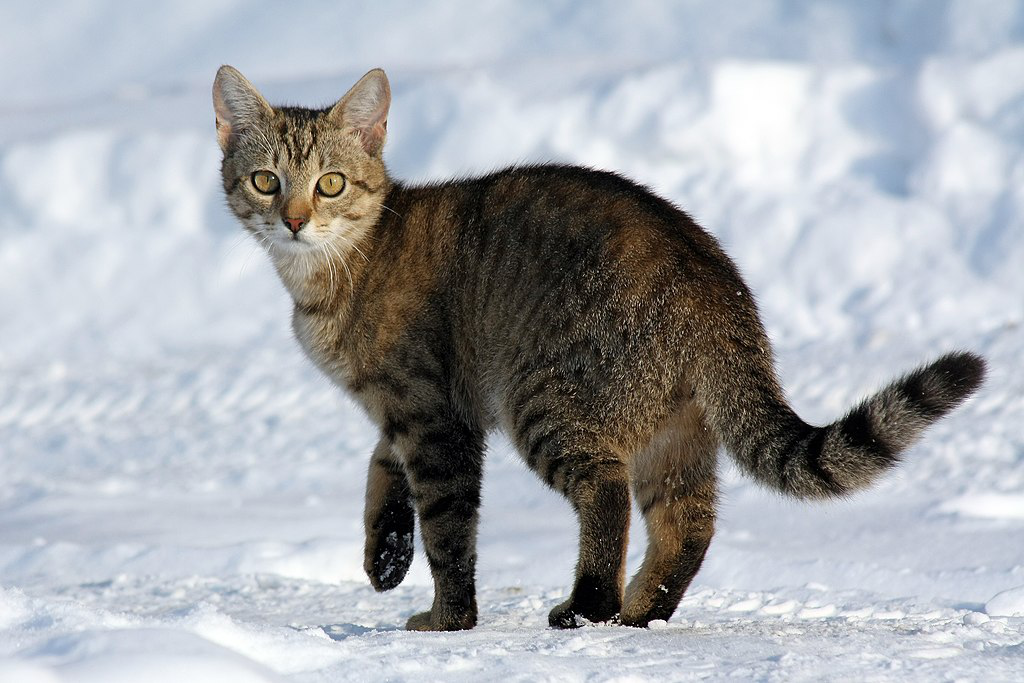

In [3]:
from IPython.display import display
display(original_PIL)

## Loading the three masks

The next part of the assignment requires that we load and explore the mask files. Let's start loading everything. The response variable is only used once and can be recycled.

In [4]:
#thruth
response = requests.get(truth_url, stream=True)
truth_PIL = Image.open(response.raw)

#mask from segmentation algorithm 1
response = requests.get(segm1_url, stream=True)
segm1_PIL = Image.open(response.raw)

#mask from segmentation algorithm 2
response = requests.get(segm2_url, stream=True)
segm2_PIL = Image.open(response.raw)

It's handy to take a look to all images together. To do that matplotlib and numpy modules will help:

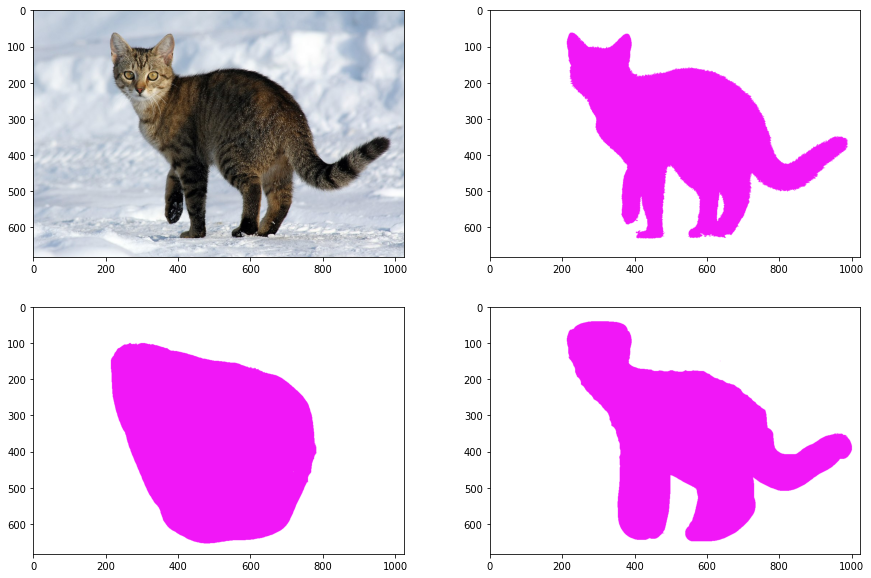

In [5]:
from matplotlib.pyplot import imshow
from matplotlib import pyplot
import numpy as np

#building a multi subplot image
fig=pyplot.figure(figsize=(15, 10))

fig.add_subplot(2,2,1)
pyplot.imshow(np.asarray(original_PIL))

fig.add_subplot(2,2,2)
pyplot.imshow(np.asarray(truth_PIL))

fig.add_subplot(2,2,3)
pyplot.imshow(np.asarray(segm1_PIL))

fig.add_subplot(2,2,4)
pyplot.imshow(np.asarray(segm2_PIL))

pyplot.show()

The top figures are the original one and the ground truth mask. The bottom figures are the result of algorithm 1 (a very poor approximation of a cat, on the left) and algorithm 2 (a slightly better cat).

Let's take a look at the metadata for the masks:

In [6]:
#let's define a handy printing function
def print_image_metadata(img, img_name):
  print("Metadata for image: " + img_name)
  print(img.format)
  print(img.size)
  print(img.mode + '\n')

#printing everythin
print_image_metadata(truth_PIL, 'Truth')
print_image_metadata(segm1_PIL, 'Algorithm 1')
print_image_metadata(segm2_PIL, 'Algorithm 2')

Metadata for image: Truth
PNG
(1024, 683)
RGBA

Metadata for image: Algorithm 1
PNG
(1024, 683)
RGBA

Metadata for image: Algorithm 2
PNG
(1024, 683)
RGBA



The good news is that all images have the same size, format (PNG) and mode (RGBA). The bad news is that the fourth channel (A = Alpha = transparency channel) is useless for this exercise and we'll need to remove it.

## Remove the alpha channel from one image

Once we have transformed the image to a 3D numpy image it will be easier to manipulate the data. In this case just removing the fourth slot from the third dimension will suffice.

In [7]:
# convert image to numpy array
truth = np.asarray(truth_PIL)

#numpy array metadata
print('Before removing alpha channel:')
print(type(truth))
print(str(truth.shape) + '\n')

#removing alpha channel
truth = np.delete(arr=truth, obj=-1, axis=2)

#check
print('After removing alpha channel')
print(type(truth))
print(str(truth.shape))

Before removing alpha channel:
<class 'numpy.ndarray'>
(683, 1024, 4)

After removing alpha channel
<class 'numpy.ndarray'>
(683, 1024, 3)


## Binarize one image

Each mask is a full color image, even if there's only two colors in it: white (background) and purple (cat). It will be handy to transform it into a simple 0/1 numeric matrix, thus losing the third dimension. Let's do that on the truth mask.

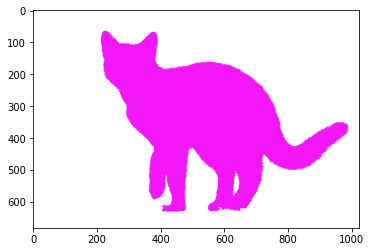

In [8]:
#taking a look, just to keep in mind our target
pyplot.imshow(truth)

In [9]:
#printing a white pixel (background) and a purple pixel (cat)
print('A background pixel:')
print(truth[0, 0])
print('\nA cat pixel:')
print(truth[300, 400])

A background pixel:
[255 255 255]

A cat pixel:
[241  23 247]


In [10]:
#each pixel is reduced to its minimum value, so that only white
#pixel stay at 255. Also, we are loosing the third dimension here.
truth = truth.min(2)

#selecting all background pixels
background_selector = truth == 255
non_background_selector = truth != 255

#background goes to zero, everything else to one
truth[background_selector] = 0
truth[non_background_selector] = 1

#printing again a white pixel (background) and a purple pixel (cat)
print('A background pixel:')
print(truth[0, 0])
print('\nA cat pixel:')
print(truth[300, 400])

A background pixel:
0

A cat pixel:
1


## Preprocess all the images

We create a function to remove the alpha channel and binarize images so we don't have to copypaste much code.

In [11]:
#put everything above in a function, so that we don't repeat for each image
def preprocess_img(PIL_image):
    #to numpy
    np_image = np.asarray(PIL_image)
    #remove alpha, if present
    np_image = np.delete(arr=np_image, obj=-1, axis=2)
    #to zero/one, losing color
    np_image = np_image.min(2)
    background_selector     = np_image == 255
    non_background_selector = np_image != 255
    np_image[background_selector] = 0
    np_image[non_background_selector] = 1

    #done
    return(np_image)

In [12]:
#preprocess the remaining images (and redo truth, for completeness)
truth = preprocess_img(truth_PIL)
segm1 = preprocess_img(segm1_PIL)
segm2 = preprocess_img(segm2_PIL)

# Pixel Accuracy

The first metric we consider is pixel accuracy, defined as the number of pixel correctly classified divided by the total number of pixels.

In [13]:
#defining a function to ease our job
def accuracy(img1, img2):
    #total number of pixels
    tot_px = img1.shape[0] * img1.shape[1]
    
    #number of matching pixels
    diff = np.count_nonzero(img1 == img2)
    
    #return the ratio
    return(diff / tot_px)

#comparing the algorithms to the truth mask
print('Accuracy')
print('truth vs. segm1: ' + str(accuracy(truth, segm1)))
print('truth vs. segm2: ' + str(accuracy(truth, segm2)))

Accuracy
truth vs. segm1: 0.8925323709736457
truth vs. segm2: 0.9410373581625183


Algorithm 2 is clearly better. However accuracy has many limitations, in particular for very unbalanced datasets (e.g. when there are much more background pixels than object ones).

# Mean Intersection over Union (IoU) - Jaccard index

This is a better metric than accuracy, and it's widely used in machine learning. For details please refer to [the wiki page](https://en.wikipedia.org/wiki/Jaccard_index).

In the field of image segmentation it's common to compute the IoU for each object class, and then mediate the values. In our example we have only two classes: zero (background) and one (cat).

We'll compute it explicitly and then using keras library.

## Mean IoU by hand

Rembember the definition of IoU for a single class:

```
for each class compute:
  IoU = |A intersect B| / |A union B|

Then average over classes
```

It's easier if we first compute the confusion matrix. Since our example is binary classification(only two classes), if we consider class 1 as "positive" and class 0 as "negative" a confusion matrix will look like the following:

```
           predicted
            values
             1    0
          +----+----+
true    1 | TP | FN |
values    +----+----+
        0 | FP | TN | 
          +----+----+
```

You can then see that:

```
IoU (class 1) = TP / (TP + FN + FP)
IoU (class 0) = TN / (TN + FN + FP)
```

Let's code it. For this example we'll compute truth-segm1 IoU. For confusion matrix we'll use sklearn module.

In [14]:
#confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth.flatten(), segm1.flatten())
print("Truth-algo1 confusion matrix")
print(cm)

#using standard statistical nomenclature (true positive, false negatives...)
TP = cm[1,1]
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]

#computing IoU for both classes, then pringing average
IoU_cl0 = TN / (TN + FP + FN)
IoU_cl1 = TP / (TP + FP + FN)

print("\nTruth-algo1 Mean IoU, by hand")
print((IoU_cl0 + IoU_cl1) / 2)

Truth-algo1 confusion matrix
[[447960  55091]
 [ 20071 176270]]

Truth-algo1 Mean IoU, by hand
0.7786923133262587


## Mean IoU using keras

Keras api contains a [MeanIoU](https://keras.io/api/metrics/segmentation_metrics/#meaniou-class) metric that greatly simplifies our work.

In [15]:
#import tensorflow as tf
from keras.metrics import MeanIoU

m = MeanIoU(num_classes=2)
m.update_state(truth.flatten(), segm1.flatten())
print("\nTruth-algo1 Mean IoU, using Keras")
print(m.result().numpy())


Truth-algo1 Mean IoU, using Keras
0.7786923


Same results as the one obtained by hand. Very good!

Let's use a function for easier comparisons.

In [16]:
def my_IoU (img1, img2):
    m = MeanIoU(num_classes=2)
    m.update_state(img1.flatten(), img2.flatten())
    return(m.result().numpy())

In [17]:
print('Mean Intersection over Union:')
print('truth vs. segm1: ' + str(my_IoU(truth, segm1)))
print('truth vs. segm2: ' + str(my_IoU(truth, segm2)))
print('truth vs. truth: ' + str(my_IoU(truth, truth)))

Mean Intersection over Union:
truth vs. segm1: 0.7786923
truth vs. segm2: 0.8690835
truth vs. truth: 1.0


As expected the second algorithm works better than the first. Moreover we confirm that if we could get a perfect result (a perfect copy of the truth mask) the IoU would be 1.

# Mean Dice coefficient

Definition: twice intersection over sum of areas. 

```
for each class compute:
  IoU = 2 x |A intersect B| / (|A| + |B|)

Then average over classes
```

As done for IoU compute the confusion matrix:

```
           predicted
            values
             1    0
          +----+----+
true    1 | TP | FN |
values    +----+----+
        0 | FP | TN | 
          +----+----+
```

It follows that:

```
Dice (class 1) = 2 * TP / (TP + FN + TN + FP) = 2 * TP / (all confusion matrix)
Dice (class 0) = 2 * TN / (TN + FP + TP + FN) = 2 * TN / (all confusion matrix)
```

Let's code it. For this example we'll use the truth-segm1 confusion matrix already computed for IoU.

In [18]:
#confusion matrix, already computed for IoU
print("Truth-algo1 confusion matrix")
print(cm)

#using standard statistical nomenclature (true positive, false negatives...)
TP = cm[1,1]
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]

#computing dice coefficinent for both classes, then printing the average
total = (TP + FN + TN + FP)
dice_cl0 = 2 * TN / total
dice_cl1 = 2 * TP / total

print("\nTruth-algo1 Dice coefficient, by hand")
print((dice_cl0 + dice_cl1) / 2)

Truth-algo1 confusion matrix
[[447960  55091]
 [ 20071 176270]]

Truth-algo1 Dice coefficient, by hand
0.8925323709736457
